# Audio Clustering using ImageBind LLM Embeddings

## Assignment Part I

This notebook demonstrates audio clustering using ImageBind's multimodal embeddings. We'll cluster audio samples based on their semantic content using state-of-the-art deep learning embeddings.

### What is Audio Clustering?
Audio clustering groups similar audio samples together based on their characteristics:
- Music genre classification
- Speaker identification
- Environmental sound categorization
- Audio similarity search

### Why ImageBind for Audio?
ImageBind provides:
- **Semantic understanding**: Captures high-level audio concepts
- **Multimodal alignment**: Audio embeddings align with vision and text
- **Pre-trained features**: No need for domain-specific training
- **Cross-modal capabilities**: Can relate audio to images, text, etc.

### Applications:
- Music recommendation systems
- Sound effect libraries organization
- Audio search engines
- Acoustic scene classification
- Voice activity detection

## 1. Installation and Setup

In [1]:
# Install required libraries
print("Installing ImageBind and audio processing libraries...\n")

# Clone ImageBind repository
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

# Install ImageBind dependencies
!pip install -e . -q
!pip install ftfy regex tqdm -q

# Install audio processing libraries
!pip install librosa soundfile -q
!pip install pydub -q

# Install clustering and visualization libraries
!pip install scikit-learn pandas numpy matplotlib seaborn -q
!pip install umap-learn -q
!pip install plotly -q

# Install youtube-dl for downloading sample audio
!pip install yt-dlp -q

print("\nInstallation complete!")

Installing ImageBind and audio processing libraries...

Cloning into 'ImageBind'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 187 (delta 84), reused 54 (delta 53), pack-reused 67 (from 3)
Receiving objects: 100% (187/187), 2.65 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/ImageBind
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

# ImageBind imports
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Clustering and evaluation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import umap

# Audio playback
from IPython.display import Audio, display

import os
import tempfile

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print("Libraries imported successfully!")

Using device: cuda
Libraries imported successfully!


## 2. Load ImageBind Model

In [3]:
# Load pre-trained ImageBind model
print("Loading ImageBind model...\n")
print("This may take a few minutes on first run (downloading weights)...\n")

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")

Loading ImageBind model...

This may take a few minutes on first run (downloading weights)...



100%|██████████| 4.47G/4.47G [04:50<00:00, 16.5MB/s]


Model loaded successfully!
Model device: cuda:0


## 3. Generate Synthetic Audio Dataset

We'll create a diverse set of synthetic audio samples representing different categories:
- Musical tones (different pitches)
- Noise patterns (white, pink)
- Rhythmic patterns
- Chirps and sweeps

In [4]:
# Generate synthetic audio samples
print("Generating synthetic audio samples...\n")

sample_rate = 16000  # ImageBind expects 16kHz
duration = 2.0  # 2 seconds per sample
n_samples = int(sample_rate * duration)
t = np.linspace(0, duration, n_samples)

audio_samples = {}
audio_categories = {}

# 1. Musical Tones - Low frequency
print("Creating musical tones...")
for i, freq in enumerate([220, 247, 262]):  # A3, B3, C4
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    # Add harmonics for richer sound
    signal += 0.25 * np.sin(2 * np.pi * freq * 2 * t)
    signal += 0.125 * np.sin(2 * np.pi * freq * 3 * t)
    # Apply envelope
    envelope = np.exp(-3 * t)
    signal = signal * envelope
    audio_samples[f'tone_low_{i+1}'] = signal
    audio_categories[f'tone_low_{i+1}'] = 'Musical-Low'

# 2. Musical Tones - High frequency
for i, freq in enumerate([880, 988, 1047]):  # A5, B5, C6
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    signal += 0.25 * np.sin(2 * np.pi * freq * 2 * t)
    envelope = np.exp(-3 * t)
    signal = signal * envelope
    audio_samples[f'tone_high_{i+1}'] = signal
    audio_categories[f'tone_high_{i+1}'] = 'Musical-High'

# 3. White Noise
print("Creating noise samples...")
for i in range(3):
    signal = np.random.normal(0, 0.1, n_samples)
    audio_samples[f'noise_white_{i+1}'] = signal
    audio_categories[f'noise_white_{i+1}'] = 'Noise-White'

# 4. Pink Noise (1/f noise)
for i in range(3):
    # Generate white noise
    white = np.random.normal(0, 1, n_samples)
    # Apply 1/f filter in frequency domain
    fft = np.fft.rfft(white)
    freqs = np.fft.rfftfreq(n_samples, 1/sample_rate)
    freqs[0] = 1  # Avoid division by zero
    pink_fft = fft / np.sqrt(freqs)
    signal = np.fft.irfft(pink_fft)
    signal = signal / np.max(np.abs(signal)) * 0.1  # Normalize
    audio_samples[f'noise_pink_{i+1}'] = signal
    audio_categories[f'noise_pink_{i+1}'] = 'Noise-Pink'

# 5. Rhythmic patterns - Fast
print("Creating rhythmic patterns...")
for i in range(3):
    tempo_hz = 4 + i * 0.5  # 4, 4.5, 5 Hz
    rhythm = np.zeros(n_samples)
    beat_interval = int(sample_rate / tempo_hz)
    for beat_start in range(0, n_samples, beat_interval):
        beat_end = min(beat_start + int(sample_rate * 0.05), n_samples)
        rhythm[beat_start:beat_end] = 0.5 * np.sin(2 * np.pi * 440 * t[beat_start:beat_end])
    audio_samples[f'rhythm_fast_{i+1}'] = rhythm
    audio_categories[f'rhythm_fast_{i+1}'] = 'Rhythm-Fast'

# 6. Rhythmic patterns - Slow
for i in range(3):
    tempo_hz = 1 + i * 0.2  # 1, 1.2, 1.4 Hz
    rhythm = np.zeros(n_samples)
    beat_interval = int(sample_rate / tempo_hz)
    for beat_start in range(0, n_samples, beat_interval):
        beat_end = min(beat_start + int(sample_rate * 0.1), n_samples)
        rhythm[beat_start:beat_end] = 0.5 * np.sin(2 * np.pi * 220 * t[beat_start:beat_end])
    audio_samples[f'rhythm_slow_{i+1}'] = rhythm
    audio_categories[f'rhythm_slow_{i+1}'] = 'Rhythm-Slow'

# 7. Chirps (frequency sweeps) - Upward
print("Creating chirps and sweeps...")
for i in range(3):
    f0 = 200 + i * 50
    f1 = 800 + i * 100
    chirp = np.sin(2 * np.pi * (f0 + (f1 - f0) * t / duration) * t)
    chirp = chirp * 0.5
    audio_samples[f'chirp_up_{i+1}'] = chirp
    audio_categories[f'chirp_up_{i+1}'] = 'Chirp-Up'

# 8. Chirps - Downward
for i in range(3):
    f0 = 800 + i * 100
    f1 = 200 + i * 50
    chirp = np.sin(2 * np.pi * (f0 + (f1 - f0) * t / duration) * t)
    chirp = chirp * 0.5
    audio_samples[f'chirp_down_{i+1}'] = chirp
    audio_categories[f'chirp_down_{i+1}'] = 'Chirp-Down'

print(f"\n✓ Generated {len(audio_samples)} audio samples")
print(f"Categories: {sorted(set(audio_categories.values()))}")
print(f"\nCategory distribution:")
category_counts = pd.Series(audio_categories.values()).value_counts()
print(category_counts)

Generating synthetic audio samples...

Creating musical tones...
Creating noise samples...
Creating rhythmic patterns...
Creating chirps and sweeps...

✓ Generated 24 audio samples
Categories: ['Chirp-Down', 'Chirp-Up', 'Musical-High', 'Musical-Low', 'Noise-Pink', 'Noise-White', 'Rhythm-Fast', 'Rhythm-Slow']

Category distribution:
Musical-Low     3
Musical-High    3
Noise-White     3
Noise-Pink      3
Rhythm-Fast     3
Rhythm-Slow     3
Chirp-Up        3
Chirp-Down      3
Name: count, dtype: int64


In [5]:
# Save audio samples to temporary files for ImageBind processing
temp_dir = tempfile.mkdtemp()
audio_paths = []
audio_names = []

print("Saving audio samples to temporary files...\n")

for name, signal in audio_samples.items():
    audio_path = os.path.join(temp_dir, f"{name}.wav")
    sf.write(audio_path, signal, sample_rate)
    audio_paths.append(audio_path)
    audio_names.append(name)

print(f"✓ Saved {len(audio_paths)} audio files")
print(f"Temp directory: {temp_dir}")

Saving audio samples to temporary files...

✓ Saved 24 audio files
Temp directory: /tmp/tmp9293sx_4


Sample audio waveforms and spectrograms:



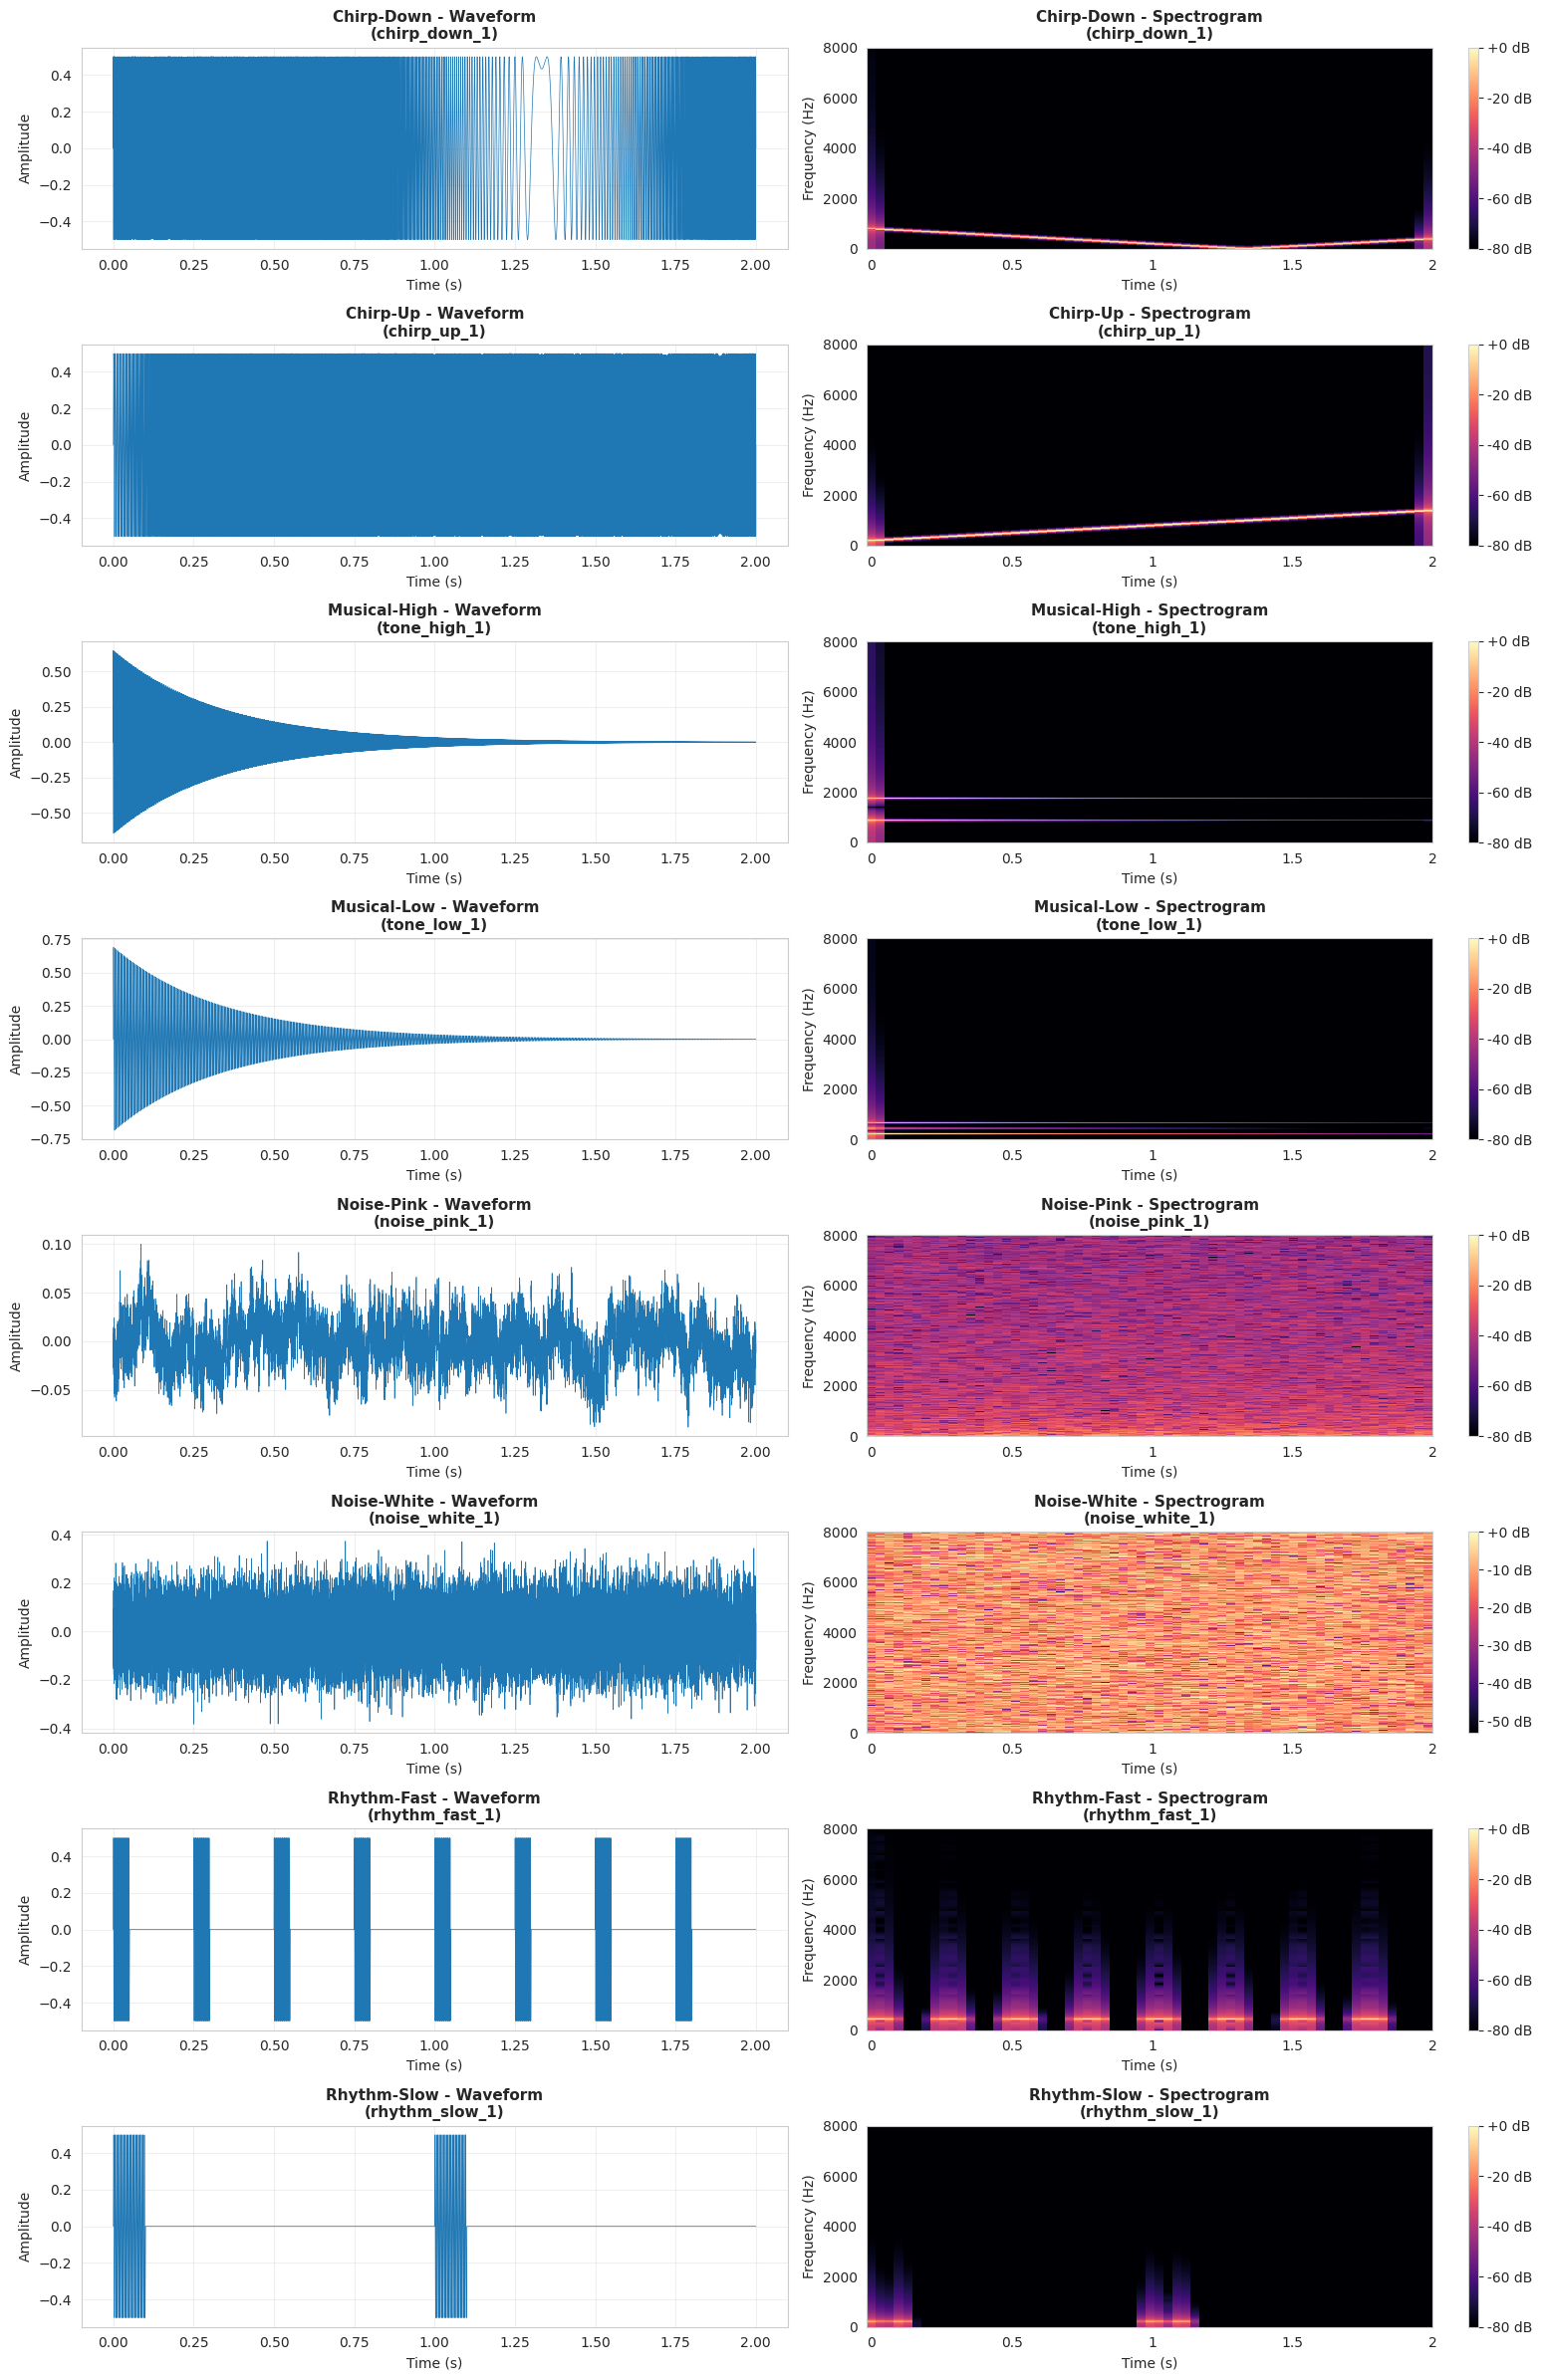

In [6]:
# Visualize sample waveforms and spectrograms
print("Sample audio waveforms and spectrograms:\n")

# Select one sample from each category
categories = sorted(set(audio_categories.values()))
sample_audios = {}

for category in categories:
    for name, cat in audio_categories.items():
        if cat == category:
            sample_audios[category] = (name, audio_samples[name])
            break

# Plot waveforms and spectrograms
fig, axes = plt.subplots(len(sample_audios), 2, figsize=(16, 3*len(sample_audios)))

for idx, (category, (name, signal)) in enumerate(sample_audios.items()):
    # Waveform
    axes[idx, 0].plot(t, signal, linewidth=0.5)
    axes[idx, 0].set_title(f'{category} - Waveform\n({name})', fontsize=11, fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True, alpha=0.3)

    # Spectrogram
    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='hz', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{category} - Spectrogram\n({name})', fontsize=11, fontweight='bold')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')
    fig.colorbar(img, ax=axes[idx, 1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [7]:
# Play sample audio clips
print("Sample audio clips (play to hear):\n")

for category, (name, signal) in list(sample_audios.items())[:3]:  # Play first 3
    print(f"\n{category} ({name}):")
    display(Audio(signal, rate=sample_rate))

Sample audio clips (play to hear):


Chirp-Down (chirp_down_1):



Chirp-Up (chirp_up_1):



Musical-High (tone_high_1):


## 4. Generate Audio Embeddings with ImageBind

In [9]:
import sys
!{sys.executable} -m pip install torchcodec -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00


In [10]:
# Generate embeddings using ImageBind
print("Generating ImageBind audio embeddings...\n")
print("This may take a minute...\n")

# Load audio for ImageBind
inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device)
}

# Generate embeddings
with torch.no_grad():
    embeddings_dict = model(inputs)

# Extract audio embeddings
embeddings = embeddings_dict[ModalityType.AUDIO].cpu().numpy()

print(f"✓ Generated embeddings successfully!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"(Number of audio samples: {embeddings.shape[0]}, Embedding dimension: {embeddings.shape[1]})")

# Create DataFrame
df_audio = pd.DataFrame({
    'name': audio_names,
    'category': [audio_categories[name] for name in audio_names]
})

print(f"\nDataset info:")
display(df_audio.head(10))
print(f"\nCategory distribution:")
print(df_audio['category'].value_counts())

Generating ImageBind audio embeddings...

This may take a minute...

✓ Generated embeddings successfully!
Embeddings shape: (24, 1024)
(Number of audio samples: 24, Embedding dimension: 1024)

Dataset info:


,name,category
0,tone_low_1,Musical-Low
1,tone_low_2,Musical-Low
2,tone_low_3,Musical-Low
3,tone_high_1,Musical-High
4,tone_high_2,Musical-High
5,tone_high_3,Musical-High
6,noise_white_1,Noise-White
7,noise_white_2,Noise-White
8,noise_white_3,Noise-White
9,noise_pink_1,Noise-Pink



Category distribution:
category
Musical-Low     3
Musical-High    3
Noise-White     3
Noise-Pink      3
Rhythm-Fast     3
Rhythm-Slow     3
Chirp-Up        3
Chirp-Down      3
Name: count, dtype: int64


## 5. Visualize Audio Embeddings

In [11]:
# Reduce dimensions for visualization
print("Reducing dimensions for visualization...\n")

# PCA
pca = PCA(n_components=min(50, len(embeddings)-1), random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE
print("Applying t-SNE...")
perplexity = min(30, len(embeddings)-1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# UMAP
print("Applying UMAP...")
n_neighbors = min(15, len(embeddings)-1)
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors)
embeddings_umap = umap_reducer.fit_transform(embeddings)

print("\n✓ Dimensionality reduction complete!")

Reducing dimensions for visualization...

PCA explained variance: 100.00%
Applying t-SNE...
Applying UMAP...

✓ Dimensionality reduction complete!


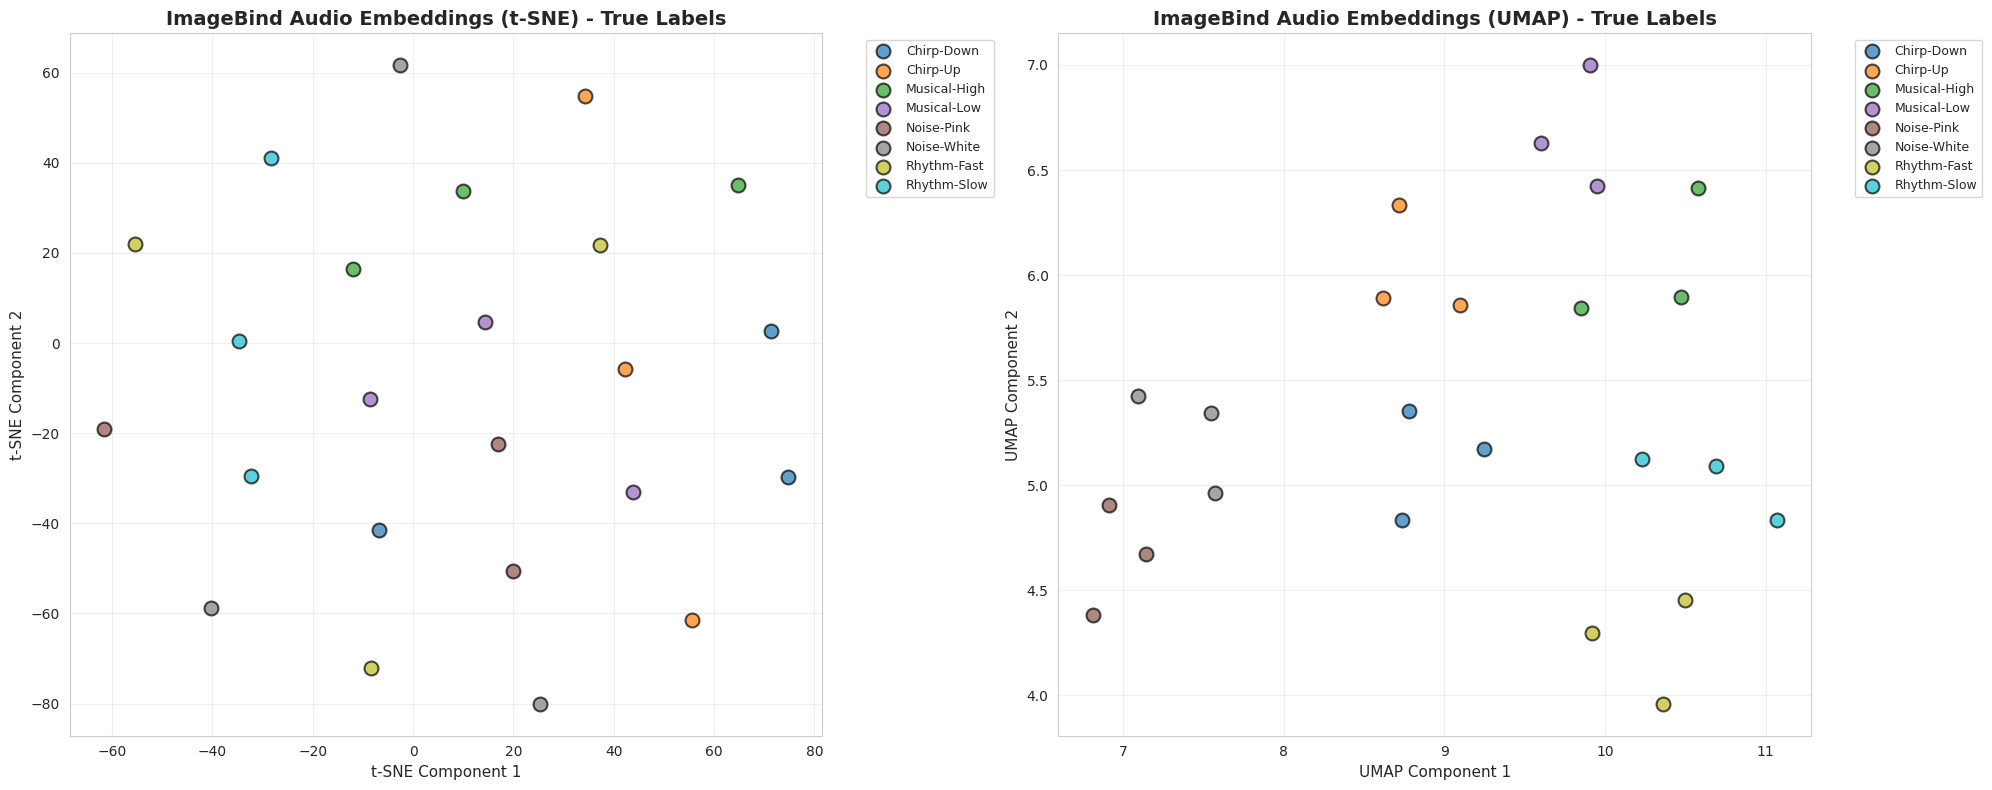

In [12]:
# Visualize embeddings with true labels
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create color map for categories
unique_categories = sorted(df_audio['category'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
category_colors = {cat: colors[i] for i, cat in enumerate(unique_categories)}

# t-SNE plot
for category in unique_categories:
    mask = df_audio['category'] == category
    axes[0].scatter(
        embeddings_tsne[mask, 0],
        embeddings_tsne[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5
    )

axes[0].set_title('ImageBind Audio Embeddings (t-SNE) - True Labels',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# UMAP plot
for category in unique_categories:
    mask = df_audio['category'] == category
    axes[1].scatter(
        embeddings_umap[mask, 0],
        embeddings_umap[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5
    )

axes[1].set_title('ImageBind Audio Embeddings (UMAP) - True Labels',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Audio Clustering

In [13]:
# K-Means clustering
n_clusters = len(unique_categories)  # Use same number as true categories

print(f"Performing K-Means clustering with {n_clusters} clusters...\n")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster labels to dataframe
df_audio['cluster'] = cluster_labels

print("Clustering complete!\n")
print("Cluster distribution:")
print(df_audio['cluster'].value_counts().sort_index())

Performing K-Means clustering with 8 clusters...

Clustering complete!

Cluster distribution:
cluster
0    3
1    3
2    3
3    3
4    3
5    3
6    3
7    3
Name: count, dtype: int64


In [14]:
# Evaluate clustering quality
print("Clustering Quality Metrics")
print("="*80)

if len(np.unique(cluster_labels)) > 1:
    silhouette = silhouette_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"\nSilhouette Score: {silhouette:.4f}")
    print("  → Range: [-1, 1], Higher is better")
    print("  → Interpretation: How well-separated the clusters are")

    print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
    print("  → Range: [0, ∞], Lower is better")
    print("  → Interpretation: Average similarity between clusters")

    print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.4f}")
    print("  → Range: [0, ∞], Higher is better")
    print("  → Interpretation: Ratio of between-cluster to within-cluster dispersion")

    print("\n" + "="*80)

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
        'Value': [silhouette, davies_bouldin, calinski_harabasz],
        'Interpretation': ['Higher is better', 'Lower is better', 'Higher is better']
    })

    print("\nMetrics Summary:")
    display(metrics_df)
else:
    print("Only one cluster found. Metrics cannot be calculated.")

Clustering Quality Metrics

Silhouette Score: 0.5918
  → Range: [-1, 1], Higher is better
  → Interpretation: How well-separated the clusters are

Davies-Bouldin Index: 0.5098
  → Range: [0, ∞], Lower is better
  → Interpretation: Average similarity between clusters

Calinski-Harabasz Score: 29.5313
  → Range: [0, ∞], Higher is better
  → Interpretation: Ratio of between-cluster to within-cluster dispersion


Metrics Summary:


,Metric,Value,Interpretation
0,Silhouette Score,0.591803,Higher is better
1,Davies-Bouldin Index,0.509774,Lower is better
2,Calinski-Harabasz Score,29.531300,Higher is better


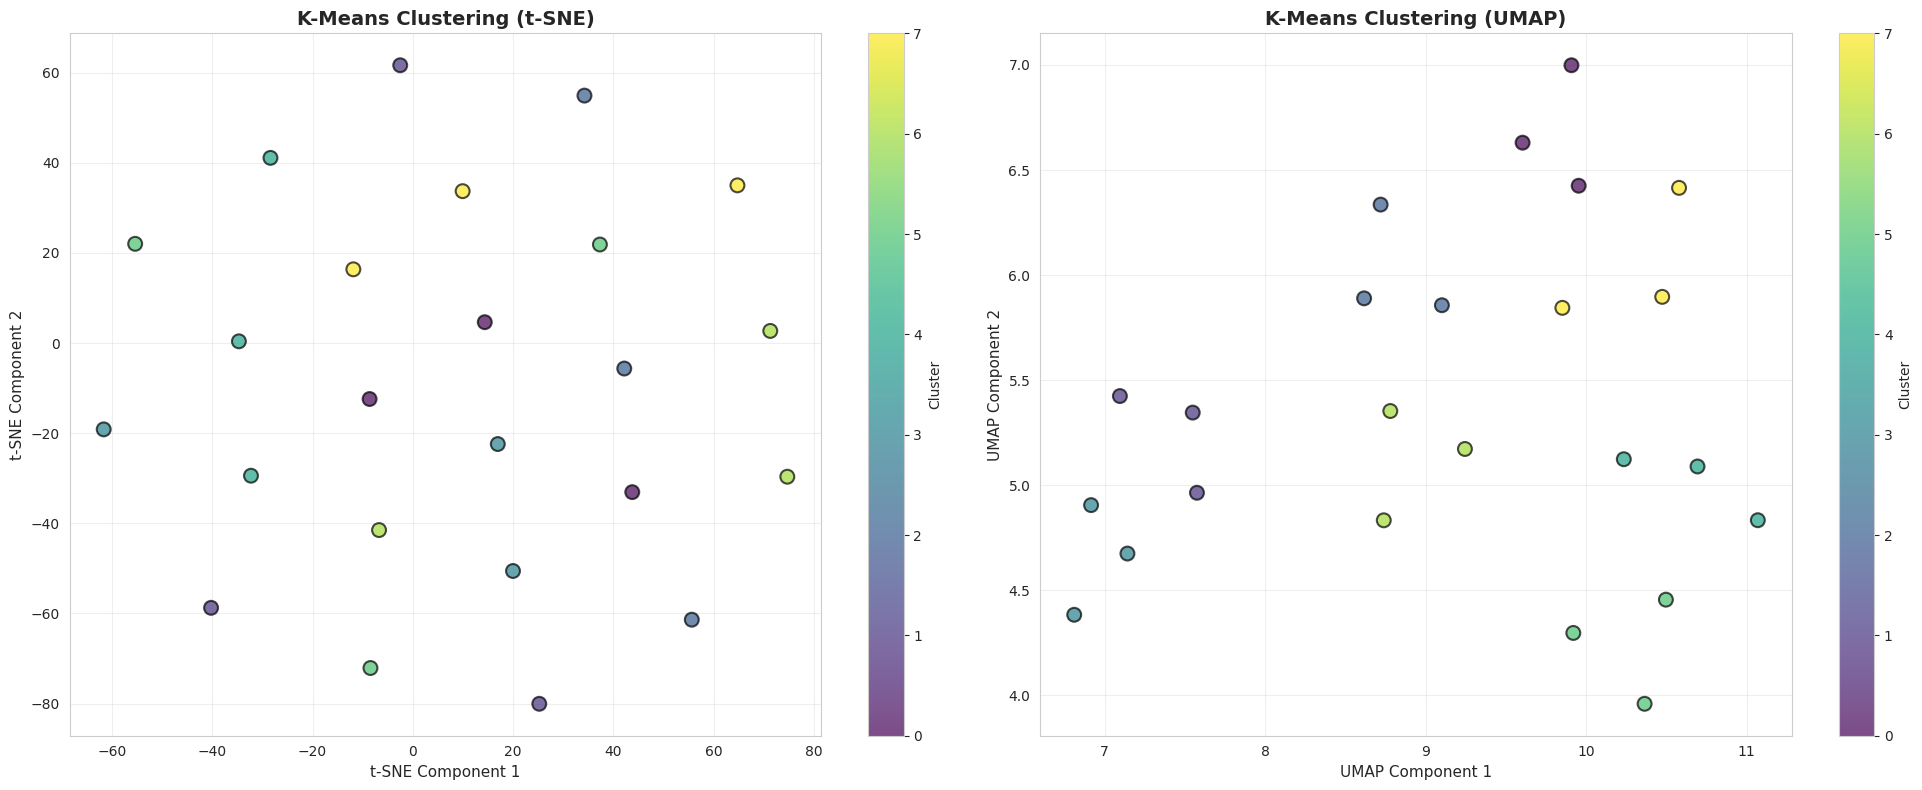

In [15]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE with cluster labels
scatter1 = axes[0].scatter(
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)

axes[0].set_title('K-Means Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# UMAP with cluster labels
scatter2 = axes[1].scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)

axes[1].set_title('K-Means Clustering (UMAP)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Cluster Analysis

In [16]:
# Analyze each cluster
print("Cluster Analysis")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_audio = df_audio[df_audio['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id}:")
    print("-" * 80)
    print(f"Size: {len(cluster_audio)} audio samples")

    # Show true category distribution
    print(f"\nTrue category distribution:")
    category_dist = cluster_audio['category'].value_counts()
    for category, count in category_dist.items():
        percentage = (count / len(cluster_audio)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")

    # Show samples in cluster
    print(f"\nSamples in Cluster {cluster_id}:")
    for idx, row in cluster_audio.iterrows():
        print(f"  - {row['name']} (True: {row['category']})")

    print("-" * 80)

print("\n" + "="*80)

Cluster Analysis

Cluster 0:
--------------------------------------------------------------------------------
Size: 3 audio samples

True category distribution:
  Musical-Low: 3 (100.0%)

Samples in Cluster 0:
  - tone_low_1 (True: Musical-Low)
  - tone_low_2 (True: Musical-Low)
  - tone_low_3 (True: Musical-Low)
--------------------------------------------------------------------------------

Cluster 1:
--------------------------------------------------------------------------------
Size: 3 audio samples

True category distribution:
  Noise-White: 3 (100.0%)

Samples in Cluster 1:
  - noise_white_1 (True: Noise-White)
  - noise_white_2 (True: Noise-White)
  - noise_white_3 (True: Noise-White)
--------------------------------------------------------------------------------

Cluster 2:
--------------------------------------------------------------------------------
Size: 3 audio samples

True category distribution:
  Chirp-Up: 3 (100.0%)

Samples in Cluster 2:
  - chirp_up_1 (True: Chir


Contingency Table (Cluster vs True Category):


category,Chirp-Down,Chirp-Up,Musical-High,Musical-Low,Noise-Pink,Noise-White,Rhythm-Fast,Rhythm-Slow,All
cluster,,,,,,,,,
0,0,0,0,3,0,0,0,0,3
1,0,0,0,0,0,3,0,0,3
2,0,3,0,0,0,0,0,0,3
3,0,0,0,0,3,0,0,0,3
4,0,0,0,0,0,0,0,3,3
5,0,0,0,0,0,0,3,0,3
6,3,0,0,0,0,0,0,0,3
7,0,0,3,0,0,0,0,0,3
All,3,3,3,3,3,3,3,3,24


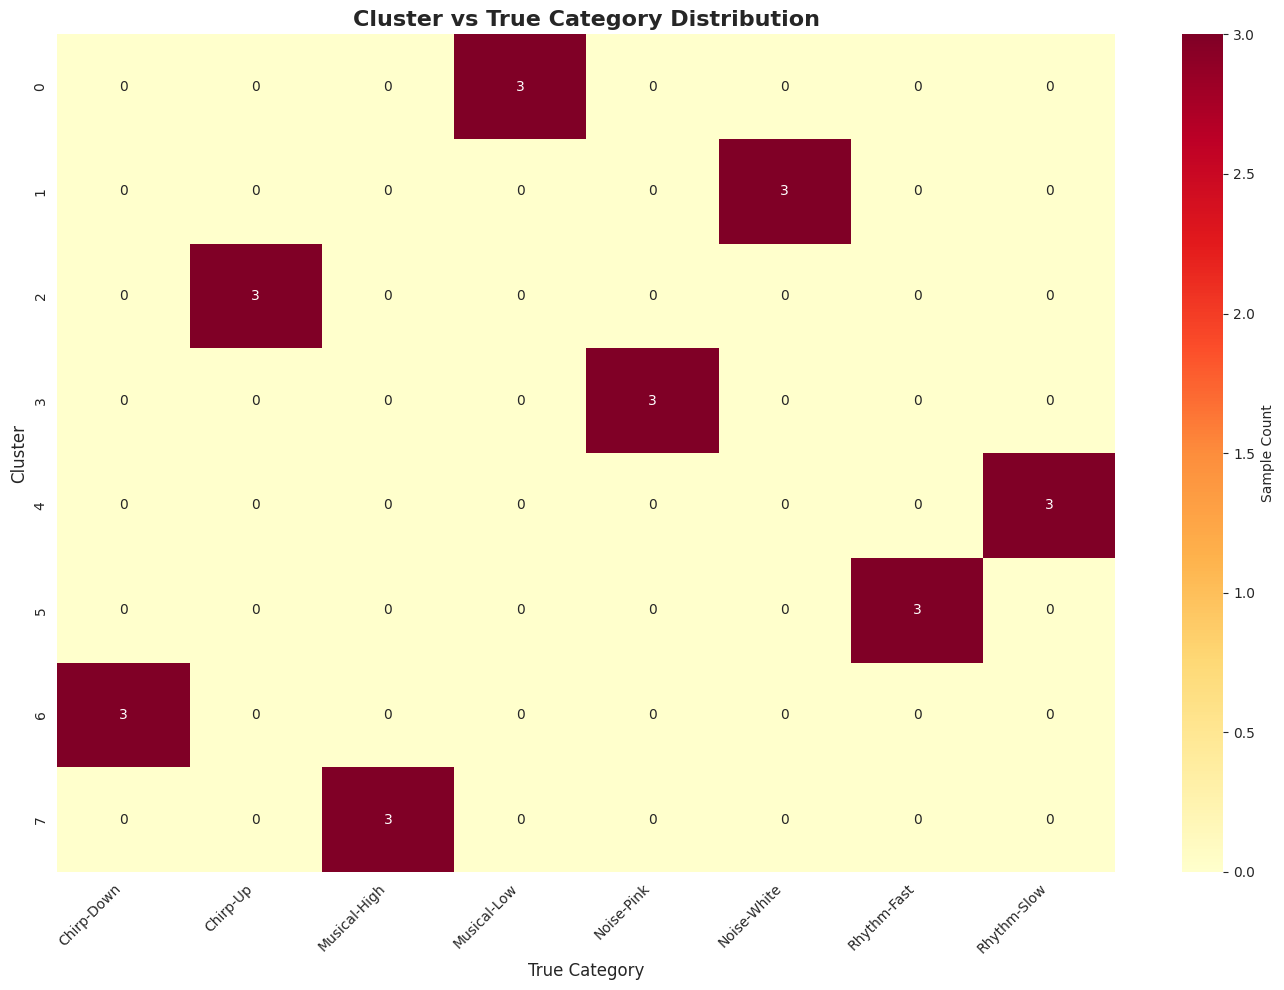

In [17]:
# Create confusion matrix between clusters and true categories
contingency_table = pd.crosstab(
    df_audio['cluster'],
    df_audio['category'],
    margins=True
)

print("\nContingency Table (Cluster vs True Category):")
print("="*80)
display(contingency_table)

# Visualize as heatmap
plt.figure(figsize=(14, 10))
contingency_no_margins = contingency_table.iloc[:-1, :-1]
sns.heatmap(contingency_no_margins, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Sample Count'})
plt.title('Cluster vs True Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('True Category', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Hierarchical Clustering

Performing Hierarchical clustering...



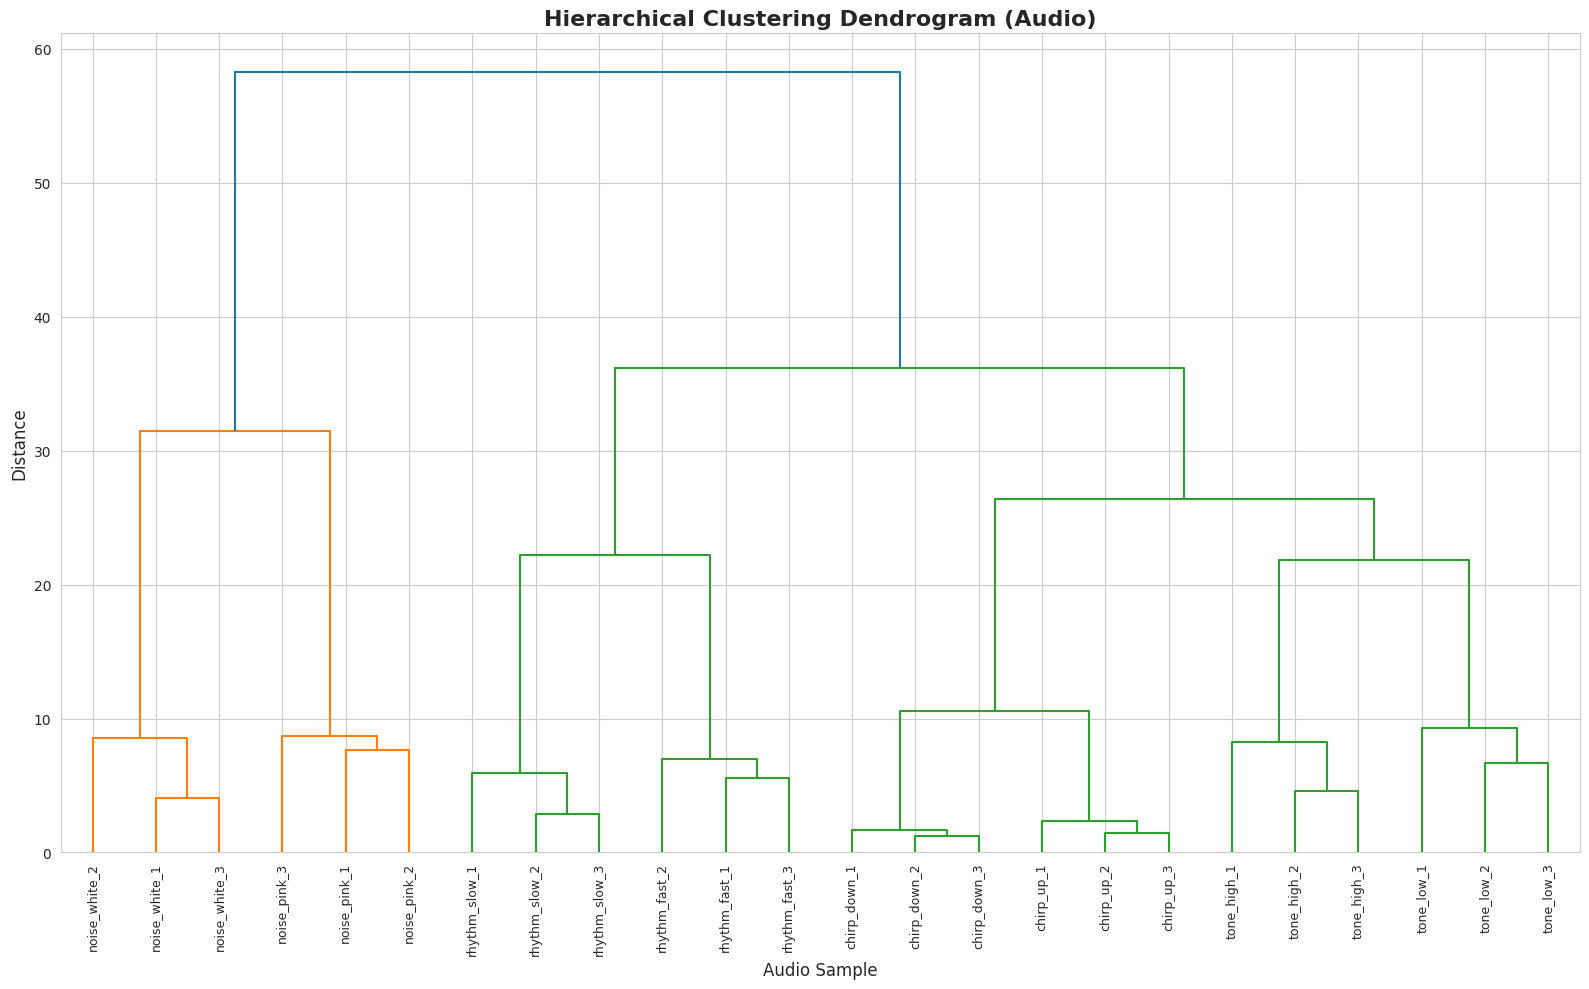

In [18]:
# Hierarchical clustering with dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

print("Performing Hierarchical clustering...\n")

linkage_matrix = linkage(embeddings, method='ward')

# Create dendrogram
plt.figure(figsize=(16, 10))
dendrogram(
    linkage_matrix,
    labels=df_audio['name'].values,
    leaf_font_size=9,
    leaf_rotation=90
)
plt.title('Hierarchical Clustering Dendrogram (Audio)', fontsize=16, fontweight='bold')
plt.xlabel('Audio Sample', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

## 9. Audio Similarity Search

In [19]:
# Find similar audio samples
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Function to find top-k similar audio samples
def find_similar_audio(query_idx, k=3):
    similarities = similarity_matrix[query_idx]
    # Exclude the query sample itself
    similar_indices = np.argsort(similarities)[::-1][1:k+1]
    return similar_indices, similarities[similar_indices]

# Example: Find similar audio for samples from different categories
print("Audio Similarity Search Results:\n")
print("="*80)

for query_idx in range(min(8, len(df_audio))):
    query_name = df_audio.iloc[query_idx]['name']
    query_category = df_audio.iloc[query_idx]['category']

    similar_indices, similarities = find_similar_audio(query_idx, k=3)

    print(f"\nQuery: {query_name} ({query_category})")
    print("Top 3 most similar audio samples:")
    for rank, (idx, sim) in enumerate(zip(similar_indices, similarities), 1):
        similar_name = df_audio.iloc[idx]['name']
        similar_category = df_audio.iloc[idx]['category']
        print(f"  {rank}. {similar_name} ({similar_category}) - Similarity: {sim:.4f}")
    print("-" * 80)

print("\n" + "="*80)

Audio Similarity Search Results:


Query: tone_low_1 (Musical-Low)
Top 3 most similar audio samples:
  1. tone_low_3 (Musical-Low) - Similarity: 0.9137
  2. tone_low_2 (Musical-Low) - Similarity: 0.8970
  3. tone_high_3 (Musical-High) - Similarity: 0.7238
--------------------------------------------------------------------------------

Query: tone_low_2 (Musical-Low)
Top 3 most similar audio samples:
  1. tone_low_3 (Musical-Low) - Similarity: 0.9448
  2. tone_low_1 (Musical-Low) - Similarity: 0.8970
  3. tone_high_3 (Musical-High) - Similarity: 0.8224
--------------------------------------------------------------------------------

Query: tone_low_3 (Musical-Low)
Top 3 most similar audio samples:
  1. tone_low_2 (Musical-Low) - Similarity: 0.9448
  2. tone_low_1 (Musical-Low) - Similarity: 0.9137
  3. tone_high_3 (Musical-High) - Similarity: 0.8149
--------------------------------------------------------------------------------

Query: tone_high_1 (Musical-High)
Top 3 most similar aud

## 10. Conclusion and Best Practices

### Key Findings:

#### 1. ImageBind for Audio Clustering:
- **Advantages**:
  - Multimodal embeddings (audio aligned with vision, text)
  - Semantic understanding beyond raw audio features
  - Pre-trained on diverse data
  - Can relate audio to other modalities
  - Single unified embedding space

- **Considerations**:
  - Requires GPU for efficient processing
  - Expects 16kHz audio (resampling needed)
  - 2-second audio clips (longer audio needs chunking)
  - Large model size

#### 2. Audio Clustering Approaches:
- **Traditional**: MFCCs, spectral features → Simple, interpretable
- **Deep Learning**: CNNs on spectrograms → Good for specific tasks
- **ImageBind**: Semantic embeddings → Best for cross-modal tasks

#### 3. Synthetic vs Real Audio:
- Synthetic audio useful for:
  - Controlled experiments
  - Testing algorithms
  - Understanding feature responses
- Real audio provides:
  - Practical validation
  - Real-world complexity
  - Better generalization testing

### Best Practices:

#### 1. Audio Preprocessing:
- **Sample rate**: Convert to 16kHz for ImageBind
- **Duration**: 2-second clips work best
- **Normalization**: Normalize amplitude
- **Format**: WAV or FLAC (lossless)
- **Mono conversion**: Convert stereo to mono if needed

#### 2. Feature Extraction:
- Use GPU when available
- Batch processing for efficiency
- Cache embeddings
- Consider chunking long audio

#### 3. Clustering:
- Try multiple algorithms
- Use appropriate number of clusters
- Validate with domain knowledge
- Consider hierarchical for exploration

#### 4. Evaluation:
- **Quantitative**: Silhouette, Davies-Bouldin, Calinski-Harabasz
- **Qualitative**: Listen to cluster contents
- **Similarity search**: Test if similar sounds cluster together

### Practical Applications:

1. **Music Organization**:
   - Genre classification
   - Mood-based grouping
   - Playlist generation
   - Similar song recommendation

2. **Sound Libraries**:
   - Automatic categorization
   - Similarity search
   - Duplicate detection
   - Tag suggestion

3. **Environmental Monitoring**:
   - Acoustic scene classification
   - Wildlife monitoring
   - Urban sound analysis
   - Anomaly detection

4. **Speech Processing**:
   - Speaker clustering
   - Language identification
   - Emotion recognition
   - Voice activity detection

### Advanced Techniques:

1. **Cross-Modal Applications**:
   - Text-to-audio search
   - Image-to-audio matching
   - Multimodal clustering

2. **Temporal Modeling**:
   - Segment long audio into chunks
   - Aggregate chunk embeddings
   - Temporal attention mechanisms

3. **Fine-tuning**:
   - Domain adaptation
   - Task-specific training
   - Metric learning

### Performance Optimization:

1. **Speed**:
   - GPU acceleration
   - Batch processing
   - Cache embeddings
   - Parallel processing

2. **Memory**:
   - Process in chunks
   - Clear cache regularly
   - Use efficient data types

3. **Quality**:
   - High-quality input audio
   - Proper preprocessing
   - Ensemble methods

### Common Challenges:

1. **Variable Length Audio**:
   - Solution: Chunk into fixed-length segments
   - Alternative: Aggregate embeddings

2. **Background Noise**:
   - Solution: Noise reduction preprocessing
   - Alternative: Robust features

3. **Diverse Audio Types**:
   - Solution: Separate processing pipelines
   - Alternative: Multi-task learning

### Next Steps:

1. Try with real audio datasets (music, speech, environmental)
2. Experiment with cross-modal retrieval (text-to-audio)
3. Fine-tune on domain-specific data
4. Build an interactive audio search system
5. Explore temporal modeling for long audio